# EECS 498-008/598-008 Assignment 6-3: Network Visualization

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Xingqi WU, #23595143

# Network Visualization

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Adversarial Attack**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.


# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['eecs598', 'network_visualization.py', 'style_transfer.py',  'network_visualization.ipynb', 'a6_helper.py', 'pytorch_autograd_and_nn.py', 'pytorch_autograd_and_nn.ipynb', 'style_transfer.ipynb', 'rnn_lstm_attention_captioning.ipynb',  'rnn_lstm_attention_captioning.py']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A1 folder, then '2020FA/A1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'A6/A6'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['network_visualization.ipynb', 'style_transfer.ipynb', 'a6_helper.py', 'eecs598', 'images', 'network_visualization.py', 'gan.py', 'style_transfer.py', 'vae.py', '__pycache__', 'fc_gan_results.jpg', 'ls_gan_results.jpg', 'dc_gan_results.jpg', 'generative_adversarial_networks.ipynb', 'vae_generation.jpg', 'conditional_vae_generation.jpg', 'variational_autoencoders.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from network_visualization.py!
```

as well as the last edit time for the file `network_visualization.py`.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from network_visualization import *
from a6_helper import *
hello()

py_path = os.path.join(GOOGLE_DRIVE_PATH, 'network_visualization.py')
py_edit_time = time.ctime(os.path.getmtime(py_path))
print('knn.py last edited on %s' % py_edit_time)

Hello from network_visualization.py!
knn.py last edited on Fri Apr 22 15:11:58 2022


Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import os
import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments without heavy computation.

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [7]:
print('Download and load the pretrained SqueezeNet model.')
model = torchvision.models.squeezenet1_1(pretrained=True).to(device='cuda')

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
# Make sure the model is in "eval" mode
model.eval()

# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

Download and load the pretrained SqueezeNet model.


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cells to visualize some of these images, along with their ground-truth labels.

In [8]:
# download imagenet_val
if os.path.isfile('imagenet_val_25.npz'):
    print('ImageNet val images exist')
else:
    print('download ImageNet val images')
    !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/imagenet_val_25.npz -P ./datasets/

download ImageNet val images
--2022-04-22 17:13:44--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/imagenet_val_25.npz
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M)
Saving to: ‘./datasets/imagenet_val_25.npz’

imagenet_val_25.npz 100%[===================>]   3.76M  2.35MB/s    in 1.6s    

2022-04-22 17:13:46 (2.35 MB/s) - ‘./datasets/imagenet_val_25.npz’ saved [3940548/3940548]



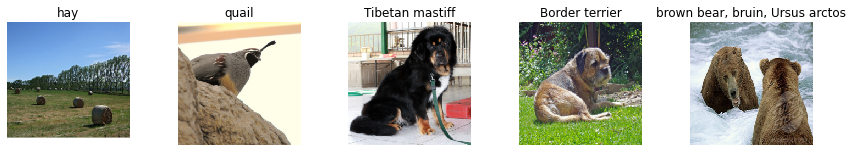

In [9]:
X, y, class_names = load_imagenet_val(num=5, path='./datasets/imagenet_val_25.npz')

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

Implement the `compute_saliency_maps` funciton and run the following to visualize some class saliency maps on our example images from the ImageNet validation set. You will be submitting the results as part of your submission.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

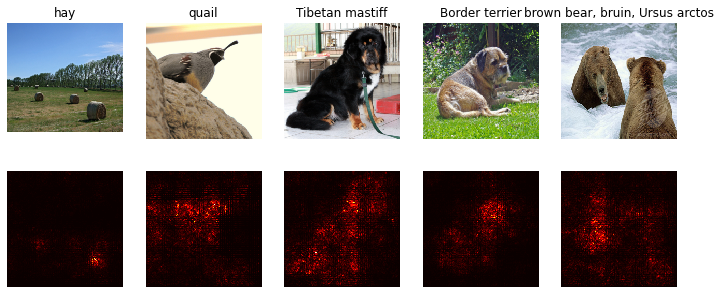

In [10]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0).to(device='cuda')
    y_tensor = torch.tensor(y, device='cuda')

    # YOUR_TURN: Impelement the compute_saliency_maps function
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.to('cpu').numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'saliency_maps_results.jpg'))
    plt.show()

show_saliency_maps(X, y)

# Adversarial Attack
We can also use image gradients to generate "adversarial attacks" as discussed in [3].
Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. 

Implement the `make_adversarial_attack` function and run the following cell to generate a $\ell_{2}$  adversarial attack. You should ideally see at first glance no major difference between the original and attacked images, and the network should now make an incorrect prediction on the attacked one. However you should see a bit of random noise if you look at the 10x magnified difference between the original and attacked images. Feel free to change the `idx` variable to explore other images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [11]:
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0).to(device='cuda')
print('Print your progress using the following format: the model is fooled if the target score and max score are the same.')
print('Iteration %d: target score %.3f, max score %.3f')
# YOUR_TURN: Impelement the make_adversarial_attack function
X_adv = make_adversarial_attack(X_tensor[idx:idx+1], target_y, model, max_iter=100)

scores = model(X_adv)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

Print your progress using the following format: the model is fooled if the target score and max score are the same.
Iteration %d: target score %.3f, max score %.3f
Iteration  1: target score 5.214, max score 24.131
Iteration  2: target score 7.481, max score 25.128
Iteration  3: target score 10.227, max score 24.528
Iteration  4: target score 13.150, max score 23.690
Iteration  5: target score 16.394, max score 22.901
Iteration  6: target score 19.378, max score 23.870
Iteration  7: target score 22.441, max score 25.474
Iteration  8: target score 25.368, max score 27.346
Iteration  9: target score 28.075, max score 28.500
Iteration 10: target score 30.775, max score 30.775

The model is fooled.


After generating an adversarially attacked image, run the following cell to visualize the original image, the attacked image, as well as the difference between them. You will be submitting the results as part of your submission.

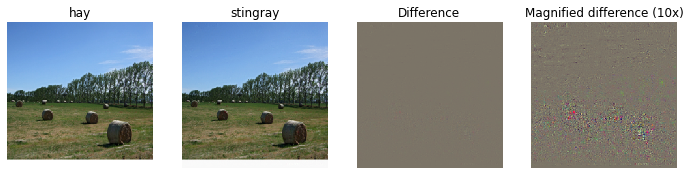

In [12]:
# checkout a6_helper.py for the implementation details of deprocess
from a6_helper import deprocess

X_adv = X_adv.to('cpu')
X_adv_np = deprocess(X_adv.clone())
X_adv_np = np.asarray(X_adv_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_adv_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_adv - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_adv - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'adversarial_attacks_results.jpg'))
plt.show()

# Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I (s_y(I) - R(I))
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [13]:
def create_class_visualization(target_y, model, class_names, device='cpu', save_fig=False, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - class_names: Dictionary for class names
    - save_fig: saves the final figure for submission
    - device: 'cpu' or 'gpu'
  
    Keyword arguments:
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to jitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn((1, 3, 224, 224), device=device).mul_(1.0).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        # YOUR_TURN: Impelement the create_class_visualization function to perform 
        # gradient step
        img = class_visualization_step(img, target_y, model) 

        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))
        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            if save_fig:
                plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'class_viz_result.jpg'))
            plt.show()

    return deprocess(img.data.cpu())

Implement the `class_visualization_step` function for performing gradient step update for class visualization. We are going to use the `create_class_visualization` (above) to generate an image that the network recognizes as the target class.

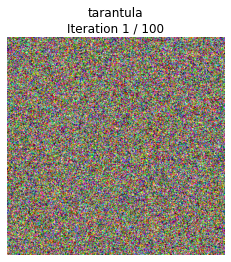

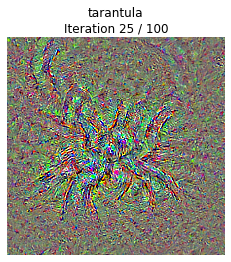

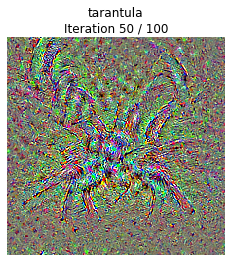

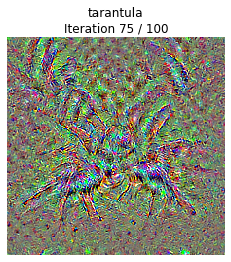

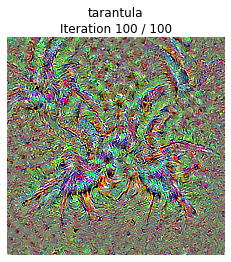

In [14]:
target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
# YOUR_TURN: make sure you have implemented the class_visualization_step function
out = create_class_visualization(target_y, model, class_names, save_fig=True, device='cuda')

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

geyser


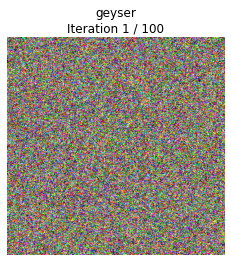

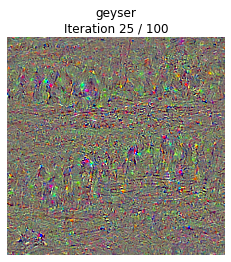

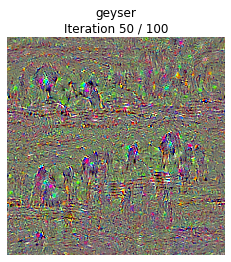

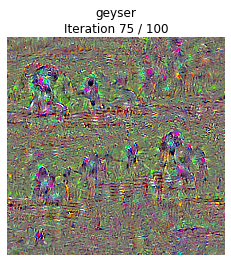

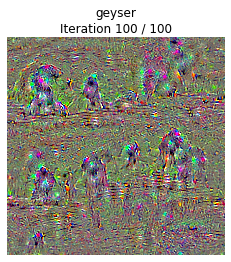

In [16]:
target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
target_y = random.randint(0,999) # [0,999]
print(class_names[target_y])
out = create_class_visualization(target_y, model, class_names, save_fig=False, device='cuda')

# Final checks
Make sure all your training results (loss + images) are saved in the notebook. You can run "Runtime -> Restart and run all..." to double check before submitting.